In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from ast import literal_eval
import numpy as np
from ast import literal_eval
plt.rcParams["svg.fonttype"] = "none"

In [41]:
naive_transcripts = pd.read_csv('Data/machine_learning_input_prep/naive_transcripts_with_fasta_clip_m6a_paris_intra_paris_inter_postar3_ric_intra_ric_inter_collapsed.bed', sep="\t")
pd.set_option('display.max_columns', None)
masterfile = pd.read_csv('Data/masterfile_with_feature_lengths/all_smOOPS_and_controls_V2_with_feature_lengths.tsv', sep="\t")
masterfile = masterfile[["transcript_id", "cds_length",	"3utr_length",	"5utr_length"]]
naive_transcripts_with_lengths = pd.merge(naive_transcripts, masterfile, on="transcript_id")
naive_transcripts_with_lengths = naive_transcripts_with_lengths.dropna(subset=["cds_length", "3utr_length", "5utr_length"])

In [70]:
def one_hot_encode(sequence, longest_sequence, encoding=['A', 'C', 'G', 'T']):

    nucleotide_to_index = tf.constant(encoding)
    nucleotides = tf.strings.bytes_split(sequence)
    indices = tf.argmax(tf.equal(tf.expand_dims(nucleotides, -1), nucleotide_to_index), axis=-1)
    one_hot_encoded = tf.one_hot(indices, depth=4)
    padded_sequence = tf.pad(one_hot_encoded, paddings=[[0, longest_sequence - tf.shape(one_hot_encoded)[0]], [0, 0]], constant_values=-1)

    return padded_sequence

def parse_crosslink_scores_full(scores, normalisation, longest_sequence):

    scores_str, column_name = scores 
    normalisation_value, columns_to_normalise = normalisation

    scores_list = tf.strings.split(scores_str, ',')
    
    converted_scores = tf.strings.to_number(scores_list, out_type=tf.float32)

    scores = converted_scores
    padded_scores = tf.concat([scores, tf.fill([longest_sequence - tf.size(scores)], -1.0)], axis=0)

    if column_name in columns_to_normalise and normalisation_value is not None:
            padded_scores = padded_scores / normalisation_value    

    return padded_scores

def predict_smoops(row, columns, columns_to_normalise,  model, mask_part):
    
    scores_list = [(row[column], column) for column in columns]
    sequence = row["sequence"]
    normalisation = row["semi_naive_mean_count"], columns_to_normalise

    longest_sequence = 16716

    if "sequence" in columns:
        combined_encoded = one_hot_encode(sequence, longest_sequence)
        combined_encoded = tf.expand_dims(combined_encoded, axis=0)
    if "sequence" not in columns:
        crosslink_scores_list = [parse_crosslink_scores_full(scores, normalisation, longest_sequence) for scores in scores_list]
        crosslink_scores_expanded = [tf.expand_dims(scores, axis=-1) for scores in crosslink_scores_list]
        combined_encoded = tf.concat(crosslink_scores_expanded, axis=-1)
        combined_encoded = tf.expand_dims(combined_encoded, axis=0)

    combined_encoded = combined_encoded.numpy()
    utr5_length = int(row["5utr_length"])
    cds_length = int(row["cds_length"])
    if mask_part == "5prime":
        combined_encoded[:, :utr5_length, :] = 0
    elif mask_part == "CDS":
        combined_encoded[:, utr5_length : utr5_length + cds_length, :] = 0
    elif mask_part == "3prime":
        combined_encoded[:, utr5_length + cds_length :, :] = 0

    prediction = model.predict(combined_encoded)
    return prediction

In [ ]:
datasets = ['sequence:', 
            'postar3', 
            'paris_intramol', 
            'global_iclip']

runs = ['training_run_12092024_163543175', 
        'training_run_12092024_163543175', 
        'training_run_12092024_090155232', 
        'training_run_12092024_090155232']

columns = [['sequence'], 
           ['AGO2_postar3' ,   'APC_postar3' ,    'CBP_postar3',     'CELF_postar3'  ,  'CELF1_postar3' ,   'CELF2_postar3' ,  'CELF4_postar3' ,  'CIRBP_postar3' ,  'CPSF6_postar3' ,  'CREBBP_postar3' , 'ELAVL1_postar3',  'EZH2_postar3','FAM120A_postar3', 'FMR1_postar3' ,   'FUS_postar3'  ,   'HNRNPR_postar3',  'LIN28A_postar3' , 'MBNL1_postar3'  ,  'MBNL2_postar3' ,  'MBNL3_postar3' ,  'MSI2_postar3'   , 'NOVA1_postar3' ,  'NOVA2_postar3'  , 'PABPC1_postar3' , 'POU5F1_postar3' , 'PTBP1_postar3'  , 'PTBP2_postar3'  , 'RBFOX1_postar3'  ,'RBFOX2_postar3' , 'RBFOX3_postar3'  ,'RBM10_postar3' ,  'RBM3_postar3'   ,  'SRRM4_postar3' ,  'SRSF1_postar3' ,  'SRSF2_postar3' ,  'SRSF3_postar3'  , 'SRSF4_postar3' ,  'SRSF7_postar3' ,  'TAF15_postar3'   ,'TARDBP_postar3' , 'TTP_postar3'   ,  'U2AF2_postar3'  , 'UPF1_postar3'  ,  'YTHDC2_postar3' , 'YY1_postar3'    ,  'ZFP36_postar3'],
           ['paris_intramol'], 
           ['global_iclip']]

columns_to_normalise = ['global_iclip', 'paris_intramol']

mask_parts = ["None", "5prime", "CDS", "3prime"]


for i, (dataset, run, column) in enumerate(zip(datasets, runs, columns)):
    print(f"Processing {dataset}, {run}, {column}")
    for mask_part in mask_parts:
        main_dir = f"Model_Training/Models/Final_Training_Run/{run}"
        model_name = os.path.join(main_dir, dataset, "saved_trained_model/full_model.h5")
        model = tf.keras.models.load_model(model_name)
        naive_transcripts_with_lengths[f'{dataset}_{mask_part}_mask_pred'] = naive_transcripts_with_lengths.apply(
                lambda row: predict_smoops(row, column, columns_to_normalise, model, mask_part), axis=1
        )

In [79]:
naive_transcripts_with_lengths.to_csv('Results/machine_learning_results/prediciton_file/naive_transcripts_with_masked_predicitons.tsv', sep="\t", index=False)

In [46]:
def plot_auc_curves(df):

    groups = {
        'sequence': [
            'sequence:_None_mask_pred',
            'sequence:_5prime_mask_pred',
            'sequence:_CDS_mask_pred',
            'sequence:_3prime_mask_pred'
        ],
        'postar3': [
            'postar3_None_mask_pred',
            'postar3_5prime_mask_pred',
            'postar3_CDS_mask_pred',
            'postar3_3prime_mask_pred'
        ],
        'paris_intraamol': [
            'paris_intramol_None_mask_pred',
            'paris_intramol_5prime_mask_pred',
            'paris_intramol_CDS_mask_pred',
            'paris_intramol_3prime_mask_pred'
        ],
        'globaliclip': [
            'global_iclip_None_mask_pred',
            'global_iclip_5prime_mask_pred',
            'global_iclip_CDS_mask_pred',
            'global_iclip_3prime_mask_pred'
        ]
    }

    y = df['smoops_naive'].astype(int)

    def extract_first_value(cell):
        if isinstance(cell, str):
            lst = literal_eval(cell)
            return lst[0][1]
        elif isinstance(cell, (list, np.ndarray)):
            return cell[0][1]
        else:
            raise ValueError(f"Unexpected cell type: {type(cell)}")

    for group_name, columns in groups.items():
        plt.figure(figsize=(4, 4))
        for col in columns:
            df[col + '_value'] = df[col].apply(extract_first_value)
            y_scores = df[col + '_value']
            fpr, tpr, _ = roc_curve(y, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{col} (AUC = {roc_auc:.2f})")
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('FPR', fontsize=16)
        plt.ylabel('TPR', fontsize=16)
        plt.legend(loc='lower right')
        plt.show()

In [22]:
naive_transcripts_with_lengths = pd.read_csv('Results/machine_learning_results/prediciton_file/naive_transcripts_with_zeroed_predicitons.tsv', sep="\t")
naive_transcripts_with_lengths

,transcript_id,score,strand,gene_name,feature,smoops_naive,smoops_epi,smoops_diff,control_common,semi_diff_mean_tpm,...,postar3_CDS_mask_pred,postar3_3prime_mask_pred,paris_intramol_None_mask_pred,paris_intramol_5prime_mask_pred,paris_intramol_CDS_mask_pred,paris_intramol_3prime_mask_pred,global_iclip_None_mask_pred,global_iclip_5prime_mask_pred,global_iclip_CDS_mask_pred,global_iclip_3prime_mask_pred
0,ENSMUST00000000080.8,.,+,Klf6,exon,False,False,False,True,23.747248,...,[[0.45802313 0.5419769 ]],[[0.01265261 0.98734736]],[[0.66717106 0.3328289 ]],[[0.67856526 0.32143468]],[[0.6812117 0.3187883]],[[0.40100148 0.59899855]],[[0.31619075 0.6838092 ]],[[0.32804403 0.671956 ]],[[0.22197449 0.7780255 ]],[[0.08460339 0.91539663]]
1,ENSMUST00000000312.12,.,+,Cdh1,exon,True,True,True,False,29.398332,...,[[0.21181649 0.7881835 ]],[[0.01379305 0.9862069 ]],[[0.12152682 0.87847316]],[[0.12691866 0.8730814 ]],[[0.21744823 0.7825518 ]],[[0.31348366 0.68651634]],[[0.02675158 0.9732484 ]],[[0.02638007 0.97361994]],[[0.01723469 0.9827654 ]],[[0.03762786 0.9623721 ]]
2,ENSMUST00000000314.13,.,+,Cdh4,exon,True,False,False,False,2.057100,...,[[0.16821028 0.8317897 ]],[[0.01247983 0.9875202 ]],[[0.3323349 0.6676651]],[[0.3323349 0.6676651]],[[0.36125627 0.6387437 ]],[[0.32359207 0.676408 ]],[[0.11750866 0.88249135]],[[0.16373238 0.8362676 ]],[[0.07195543 0.92804456]],[[0.03680846 0.9631915 ]]
3,ENSMUST00000000543.6,.,+,Tamalin,exon,False,False,False,True,1.173358,...,[[0.9343633 0.06563673]],[[0.01218216 0.9878178 ]],[[0.5835444 0.41645563]],[[0.63759285 0.36240712]],[[0.5193723 0.48062775]],[[0.22032559 0.7796744 ]],[[0.88019985 0.1198002 ]],[[0.9475788 0.05242119]],[[0.86786693 0.13213308]],[[0.03722711 0.96277285]]
4,ENSMUST00000000619.8,.,-,Clcn4,exon,False,False,False,True,1.947124,...,[[0.3833136 0.61668646]],[[0.20122181 0.7987782 ]],[[0.40810937 0.59189063]],[[0.40810937 0.59189063]],[[0.40810937 0.59189063]],[[0.38011235 0.6198877 ]],[[0.45261192 0.54738814]],[[0.4253018 0.5746982]],[[0.24845089 0.7515491 ]],[[0.15890175 0.8410982 ]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,ENSMUST00000239433.2,.,+,Ubap1l,exon,False,False,False,True,0.244148,...,[[0.9144646 0.08553541]],[[0.01218216 0.9878178 ]],[[0.84973264 0.15026736]],[[0.84973264 0.15026736]],[[0.84973264 0.15026736]],[[0.38011235 0.6198877 ]],[[0.8693035 0.13069643]],[[0.8693035 0.13069643]],[[0.9612366 0.03876335]],[[0.03119612 0.9688038 ]]
1303,ENSMUST00000239462.2,.,-,Snx14,exon,False,False,False,True,5.713211,...,[[0.8499644 0.15003565]],[[0.08526771 0.9147323 ]],[[0.8583628 0.14163719]],[[0.8583628 0.14163719]],[[0.88797987 0.11202013]],[[0.34972712 0.6502729 ]],[[0.81917787 0.1808222 ]],[[0.8202044 0.17979568]],[[0.8122366 0.18776338]],[[0.23905016 0.7609499 ]]
1304,ENSMUST00000239506.1,.,+,Spata5l1,exon,False,False,False,True,3.550297,...,[[0.93118894 0.06881112]],[[0.0112103 0.9887897]],[[0.8599878 0.14001223]],[[0.87056476 0.1294352 ]],[[0.8187243 0.18127568]],[[0.35850528 0.6414947 ]],[[0.9483095 0.05169059]],[[0.9559501 0.04404993]],[[0.9704241 0.02957595]],[[0.06132622 0.93867373]]
1305,ENSMUST00000239512.1,.,-,Lin54,exon,False,False,False,True,8.714442,...,[[0.39408115 0.6059188 ]],[[0.04310646 0.9568935 ]],[[0.48883837 0.5111616 ]],[[0.48883837 0.5111616 ]],[[0.6575529 0.3424471]],[[0.33612388 0.6638761 ]],[[0.6986498 0.30135018]],[[0.7105026 0.28949738]],[[0.43892765 0.56107235]],[[0.30759135 0.6924086 ]]


/tmp/ipykernel_3375246/2340841912.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naive_transcripts_with_lengths_only_predictions_and_group[col] = naive_transcripts_with_lengths_only_predictions_and_group[col].apply(parse_string_to_array)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

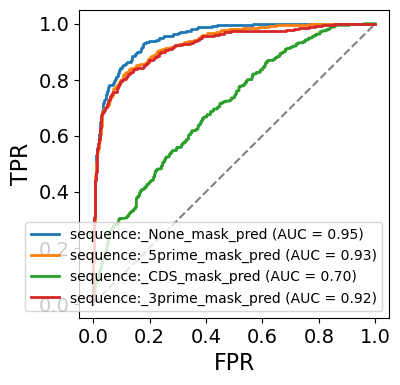

/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

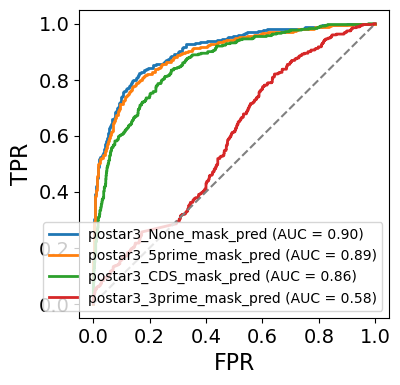

/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

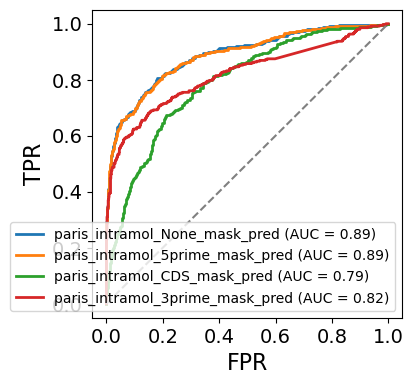

/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_value'] = df[col].apply(extract_first_value)
/tmp/ipykernel_3375246/2997333998.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

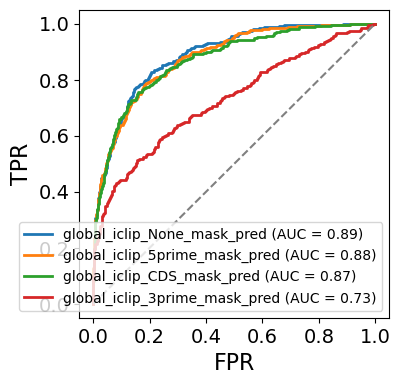

In [49]:
naive_transcripts_with_lengths_only_predictions_and_group = naive_transcripts_with_lengths[["smoops_naive", 
                                                                                            "sequence:_None_mask_pred"	,
                                                                                            "sequence:_5prime_mask_pred"	,
                                                                                            "sequence:_CDS_mask_pred"	,
                                                                                            "sequence:_3prime_mask_pred"	,
                                                                                            "postar3_None_mask_pred"	,
                                                                                            "postar3_5prime_mask_pred"	,
                                                                                            "postar3_CDS_mask_pred"	,
                                                                                            "postar3_3prime_mask_pred"	,
                                                                                            "paris_intramol_None_mask_pred"	,
                                                                                            "paris_intramol_5prime_mask_pred"	,
                                                                                            "paris_intramol_CDS_mask_pred"	,
                                                                                            "paris_intramol_3prime_mask_pred"	,
                                                                                            "global_iclip_None_mask_pred"	,
                                                                                            "global_iclip_5prime_mask_pred"	,
                                                                                            "global_iclip_CDS_mask_pred"	,
                                                                                            "global_iclip_3prime_mask_pred"]]
naive_transcripts_with_lengths_only_predictions_and_group

def parse_string_to_array(cell):
    if isinstance(cell, str):

        cleaned_str = re.sub(r'\s+', ',', cell)
        try:
            return np.array(literal_eval(cleaned_str))
        except (SyntaxError, ValueError):

            print(f"Could not parse: {cell}")
            return np.nan  # or handle it differently
    return cell

for col in naive_transcripts_with_lengths_only_predictions_and_group.columns[1:]:
    naive_transcripts_with_lengths_only_predictions_and_group[col] = naive_transcripts_with_lengths_only_predictions_and_group[col].apply(parse_string_to_array)

plot_auc_curves(naive_transcripts_with_lengths_only_predictions_and_group)
